# Preprocess
* Import kaggle dataset
* Data Understanding
* Text cleaning (emoji, mentions, puntuactions,..)
* Terms tokenization & reduction (lemmatization, bigrams,..)
* Visual rapresentantion (Word Cloud and frequency) -> for this task I decide to remove all the stop-words in order to highlight the most frequent words of the context

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Text cleaning
import re, string
from stop_words import get_stop_words
import emoji

#nltk
import nltk
from nltk import ngrams
from nltk.stem import WordNetLemmatizer,SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator

stemmer = SnowballStemmer("english")

#### Import dataset

In [2]:
df = pd.read_csv('Data/cyberbullying_tweets.csv')

In [3]:
df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


In [4]:
df = df.rename(columns={'tweet_text': 'Tweet', 'cyberbullying_type': 'cat_Type'})

Upon observing some of the tweets in the 'other_cyberbullying' category, I discovered that they were random tweets without any bullying overtones, so I decided to remove them - instead of putting them in the 'not_cyberbullying' category.

In [5]:
#drop rows with labels "other cyberbullying"
df = df.drop(df[df.cat_Type == "other_cyberbullying"].index)

In [6]:
df.shape

(39869, 2)

In [7]:
df = df.drop_duplicates()

#### Charateristics of target variable

C:\Users\Martina\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


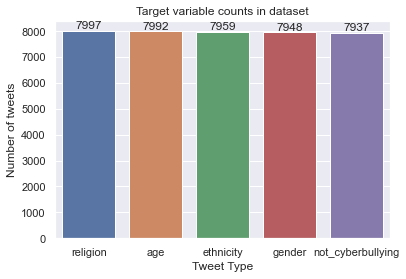

In [8]:
unique= df["cat_Type"].unique()
freq = df["cat_Type"].value_counts()
sns.set(font_scale = 1)

ax = sns.countplot(df["cat_Type"], 
                   order = df["cat_Type"].value_counts().index)
plt.title("Target variable counts in dataset")
plt.ylabel('Number of tweets')
plt.xlabel('Tweet Type')

# adding the text labels
rects = ax.patches
for rect, label in zip(rects, freq):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    
plt.show()

In [9]:
#convert category into numbers
d = {"not_cyberbullying": 0, "religion": 1, "age": 2, "gender": 3, "ethnicity": 4}
df['Type'] = df['cat_Type'].map(d)

In [10]:
df

,Tweet,cat_Type,Type
0,"In other words #katandandre, your food was cra...",not_cyberbullying,0
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,0
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,0
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,0
...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,4
47688,Turner did not withhold his disappointment. Tu...,ethnicity,4
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,4
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,4


In [11]:
df.to_csv("preprocess_tweet.csv")

## Tweets text cleaning

In [12]:
#DETERMINE ALL STOP WORDS
stop_words = get_stop_words('english')
stp_wrd = ['','r', 're', 'rt', 'didn', 'bc', 'n', 'm', 'im', 'll', 'y', 've', 'u', 'ur', 'don', 't', 's', 'b', 'ima',
                  'al', 'yeah', 'get', 'ppl', 'etc', 'http', 'tco']

stop_words.extend(stp_wrd)

#Clean emoticons from text
def emoticon_remove(text):
    text = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', '', text)
    return text

#Remove punctuation, links, stopwords, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = re.sub(r'http\S+', "", text) #remove links
    text = re.sub(r'(@\w+)|#|&|!', "", text) #remove mentions
    text = text.replace('/', ' ') #remove "/"
    text = text.replace('\r', '').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    text = re.sub(r'[0-9\.]+', '', text) #remove numbers
    banned_list= string.punctuation #remove punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    text =' '.join(word for word in text.split() if len(word) < 14) # remove words longer than 14 characters
    return text


#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the "#" symbol
def clean_hashtags(text):
    text = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text)) #remove last hashtags
    text = " ".join(word.strip() for word in re.split('#|_', text)) #remove hashtags symbol from words in the middle of the sentence
    return text

def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"won\'t", "will not", text)
    
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    
    text = re.sub(r"cant", "can not", text)
    text = re.sub(r"wont", "will not", text)
    text = re.sub(r"wasnt", "was not", text)
    text = re.sub(r"ive", "i have", text)
    text = re.sub(r"dont", "do not", text)
    text = re.sub(r"didnt", "did not", text)
    text = re.sub(r"aim", "i am", text)
    text = re.sub(r"aint", "am not", text)
    text = re.sub(r"youre", "you are", text)
    text = re.sub(r"isnt", "is not", text)
    text = re.sub(r"isn", "is not", text)

    text = re.sub(r"thanx", "thank you", text)
    text = re.sub(r"shyt", "shit", text)
    text = re.sub(r"pls", "please", text)
    return text

#Filter special characters such as "&" and "$" present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

#Remove multiple sequential spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

#Stemming
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = SnowballStemmer("english")
    return ' '.join([ps.stem(words) for words in tokenized])

In [13]:
#Lemmatization 
# Initialize the lemmatizer
wl = WordNetLemmatizer()

# function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [14]:
#Then we apply all the defined functions in the following order
def preprocess(text):
    text = emoticon_remove(text)
    text = strip_all_entities(text)
    text = decontract(text)
    #text = clean_hashtags(text) #I decide to maintain hashtag because they might be useful to cyberbullying detection 
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    #NEWS
    text = lemmatizer(text) 
    text = re.sub(r"isi", "isis", text)
    return text

In [15]:
df['text_clean'] = df['Tweet'].apply(lambda x: preprocess(x))

In [16]:
df.head()

,Tweet,cat_Type,Type,text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,0,word katandandre food crapilicious mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,0,aussietv white mkr theblock today sunrise stud...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,0,classy whore red velvet cupcake
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,0,meh thanks head concern another angry dude twi...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,0,isis account pretend kurdish account like isla...


In [17]:
#TOKENIZATION
def tokenization(text):
    text = re.split('\W+', text)
    return text

df['Tweet_tokenized'] = df['text_clean'].apply(lambda x: tokenization(x))

In [18]:
df['tokenized_bigram'] = df['Tweet_tokenized'].apply(lambda words: list(nltk.ngrams(words, 2)))

In [19]:
df.head(10)

,Tweet,cat_Type,Type,text_clean,Tweet_tokenized,tokenized_bigram
0,"In other words #katandandre, your food was cra...",not_cyberbullying,0,word katandandre food crapilicious mkr,"[word, katandandre, food, crapilicious, mkr]","[(word, katandandre), (katandandre, food), (fo..."
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,0,aussietv white mkr theblock today sunrise stud...,"[aussietv, white, mkr, theblock, today, sunris...","[(aussietv, white), (white, mkr), (mkr, theblo..."
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,0,classy whore red velvet cupcake,"[classy, whore, red, velvet, cupcake]","[(classy, whore), (whore, red), (red, velvet),..."
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,0,meh thanks head concern another angry dude twi...,"[meh, thanks, head, concern, another, angry, d...","[(meh, thanks), (thanks, head), (head, concern..."
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,0,isis account pretend kurdish account like isla...,"[isis, account, pretend, kurdish, account, lik...","[(isis, account), (account, pretend), (pretend..."
5,"@Raja5aab @Quickieleaks Yes, the test of god i...",not_cyberbullying,0,yes test god good bad indifferent weird whatev...,"[yes, test, god, good, bad, indifferent, weird...","[(yes, test), (test, god), (god, good), (good,..."
6,Itu sekolah ya bukan tempat bully! Ga jauh kay...,not_cyberbullying,0,itu sekolah ya bukan tempat bully ga jauh kaya...,"[itu, sekolah, ya, bukan, tempat, bully, ga, j...","[(itu, sekolah), (sekolah, ya), (ya, bukan), (..."
7,Karma. I hope it bites Kat on the butt. She is...,not_cyberbullying,0,karma hope bite kat butt just nasty mkr,"[karma, hope, bite, kat, butt, just, nasty, mkr]","[(karma, hope), (hope, bite), (bite, kat), (ka..."
8,@stockputout everything but mostly my priest,not_cyberbullying,0,everything mostly priest,"[everything, mostly, priest]","[(everything, mostly), (mostly, priest)]"
9,Rebecca Black Drops Out of School Due to Bully...,not_cyberbullying,0,rebecca black drops school due bullying,"[rebecca, black, drops, school, due, bullying]","[(rebecca, black), (black, drops), (drops, sch..."


In [20]:
df.drop_duplicates("text_clean", inplace=True)

In [21]:
df.shape

(38684, 6)

### Frequencies

In [22]:
#WORDS FREQUENCY
text = list()
for tweet in df['Tweet_tokenized']:
    for el in tweet:
        text.append(el)
    
freq_dist = nltk.FreqDist(text)

freq_dist.most_common(20)

[('bully', 9561),
 ('school', 9033),
 ('not', 8068),
 ('fuck', 6898),
 ('like', 5690),
 ('nigger', 5432),
 ('joke', 5364),
 ('do', 5322),
 ('girl', 5305),
 ('high', 5141),
 ('dumb', 5127),
 ('people', 4451),
 ('muslim', 4350),
 ('gay', 4275),
 ('rape', 4206),
 ('say', 4094),
 ('just', 3985),
 ('have', 3804),
 ('can', 3778),
 ('call', 3772)]

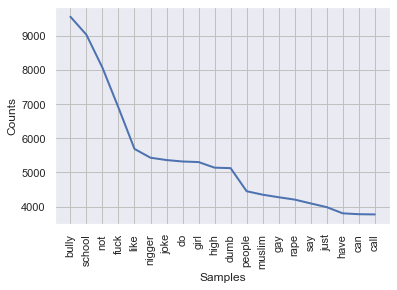

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [23]:
freq_dist.plot(20)

In [24]:
nltk_text = nltk.Text(text)

# Word cloud & Bi-grams

* "not_cyberbullying": 0 
* "religion": 1
* "age": 2 
* "gender": 3
* "ethnicity": 4

### Not cyberbullying

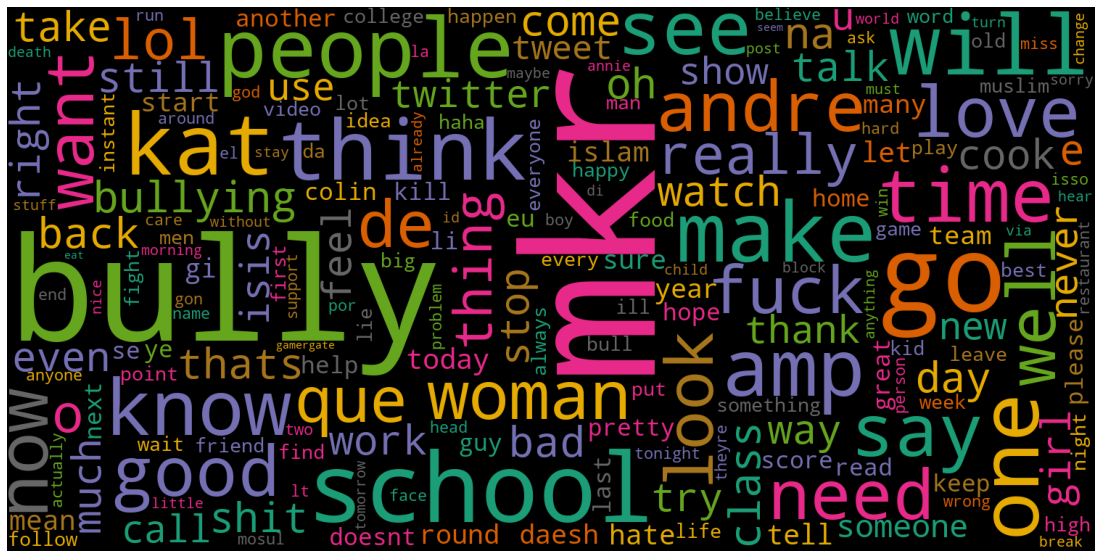

In [25]:
plt.figure(figsize=(20,10))
subset_notc = df[df['Type']==0]

text_notc = list()
for el in subset_notc.Tweet_tokenized.values:
    for i in el:
        text_notc.append(i)
        
cloud1 = WordCloud(background_color='black',colormap="Dark2", 
                   collocations=False,width=1500,height=750).generate(" ".join(text_notc))

plt.axis('off')
#plt.title("Not-Bullying",fontsize=40)
plt.imshow(cloud1)

In [26]:
freq_notc = nltk.FreqDist(text_notc)
freq_notc.most_common(10)

[('mkr', 1628),
 ('bully', 954),
 ('not', 785),
 ('do', 513),
 ('go', 469),
 ('can', 468),
 ('just', 442),
 ('like', 412),
 ('have', 399),
 ('school', 376)]

In [27]:
#WORDS FREQUENCY _ 1Gram e 2Gram

bigram_notc = list()
for tweet in subset_notc['Tweet_tokenized']:
    for i in range (0, len(tweet)-1):
        bigram_notc.append((tweet[i], tweet[i+1]))
    
big_freq_notc = nltk.FreqDist(bigram_notc)

big_freq_notc.most_common(20)

[(('do', 'not'), 451),
 (('can', 'not'), 181),
 (('kat', 'andre'), 134),
 (('i', 'have'), 111),
 (('be', 'not'), 100),
 (('you', 'be'), 98),
 (('mkr', 'mkr'), 74),
 (('gi', 'have'), 68),
 (('li', 'have'), 55),
 (('gon', 'na'), 51),
 (('kat', 'amp'), 51),
 (('amp', 'andre'), 46),
 (('will', 'not'), 45),
 (('instant', 'restaurant'), 45),
 (('look', 'like'), 38),
 (('not', 'know'), 38),
 (('wan', 'na'), 35),
 (('not', 'even'), 35),
 (('de', 'bully'), 32),
 (('high', 'school'), 32)]

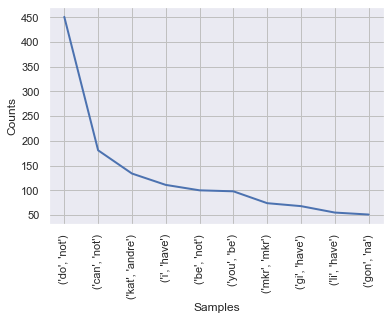

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [28]:
big_freq_notc.plot(10)

### Religion

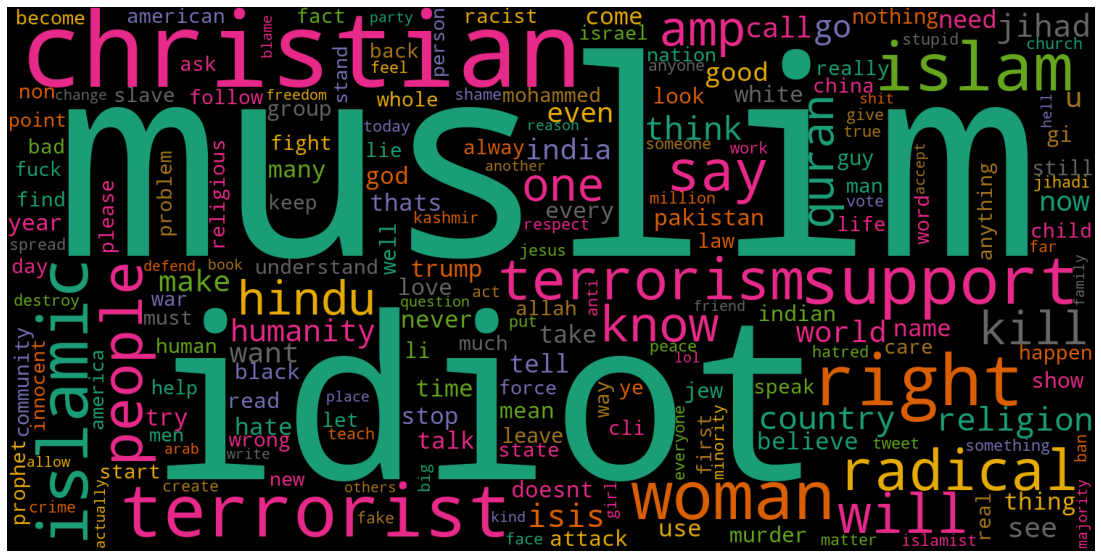

In [29]:
plt.figure(figsize=(20,10))
subset_rel = df[df['Type']==1]

text_rel = list()
for el in subset_rel.Tweet_tokenized.values:
    for i in el:
        text_rel.append(i)
        
cloud1 = WordCloud(background_color='black',colormap="Dark2", 
                   collocations=False,width=1500,height=750).generate(" ".join(text_rel))

plt.axis('off')
#plt.title("Religion",fontsize=40)
plt.imshow(cloud1)

In [30]:
freq_rel = nltk.FreqDist(text_rel)
freq_rel.most_common(10)

[('muslim', 4237),
 ('idiot', 2868),
 ('christian', 2035),
 ('not', 2024),
 ('do', 1502),
 ('terrorist', 1336),
 ('right', 1289),
 ('like', 1257),
 ('islamic', 1246),
 ('woman', 1233)]

In [31]:
#WORDS FREQUENCY _ BiGrams

bigram_rel = list()
for tweet in subset_rel['Tweet_tokenized']:
    for i in range (0, len(tweet)-1):
        bigram_rel.append((tweet[i], tweet[i+1]))
    
big_freq_rel = nltk.FreqDist(bigram_rel)

big_freq_rel.most_common(20)

[(('do', 'not'), 1361),
 (('christian', 'woman'), 815),
 (('islamic', 'terrorism'), 810),
 (('you', 'be'), 454),
 (('can', 'not'), 335),
 (('li', 'have'), 244),
 (('radical', 'islamic'), 210),
 (('be', 'not'), 182),
 (('gi', 'have'), 180),
 (('idiot', 'like'), 142),
 (('muslim', 'country'), 127),
 (('muslim', 'idiot'), 125),
 (('support', 'radical'), 120),
 (('radical', 'christian'), 116),
 (('will', 'not'), 108),
 (('good', 'christian'), 107),
 (('not', 'know'), 105),
 (('non', 'muslim'), 94),
 (('right', 'now'), 93),
 (('woman', 'right'), 92)]

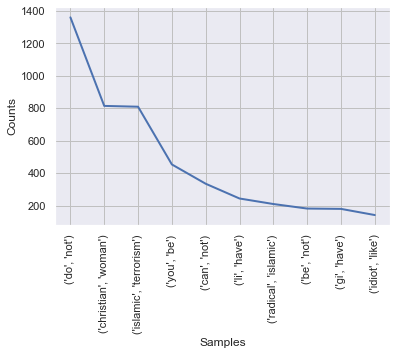

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [32]:
big_freq_rel.plot(10)

### Age

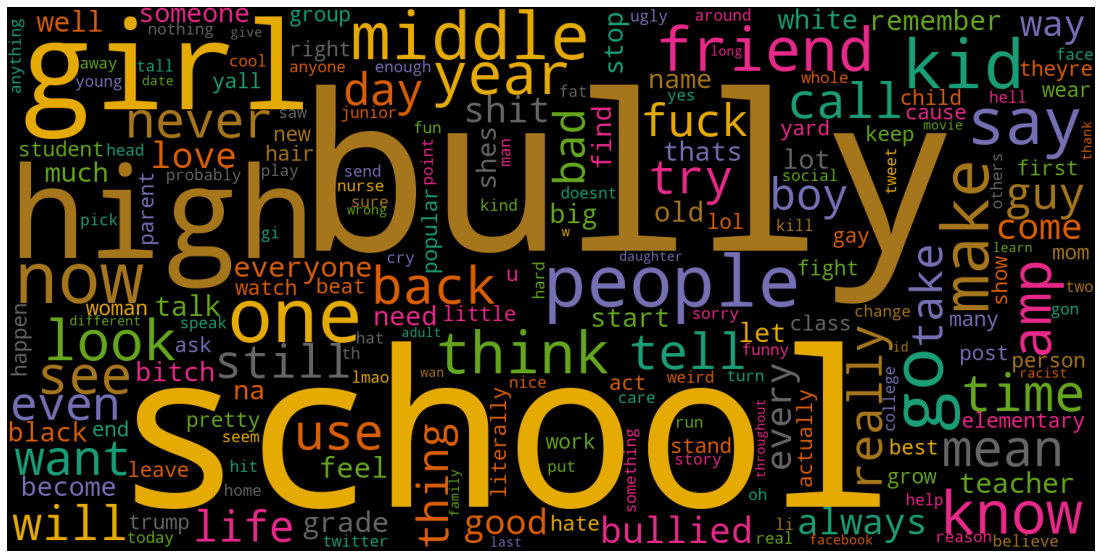

In [33]:
plt.figure(figsize=(20,10))
subset_age = df[df['Type']==2]

text_age = list()
for el in subset_age.Tweet_tokenized.values:
    for i in el:
        text_age.append(i)
        
cloud1 = WordCloud(background_color='black',colormap="Dark2", 
                   collocations=False,width=1500,height=750).generate(" ".join(text_age))

plt.axis('off')
#plt.title("Age",fontsize=40)
plt.imshow(cloud1)

In [34]:
freq_age = nltk.FreqDist(text_age)
freq_age.most_common(10)

[('bully', 8525),
 ('school', 8442),
 ('high', 4957),
 ('girl', 4523),
 ('like', 2037),
 ('not', 1690),
 ('get', 1201),
 ('do', 1105),
 ('just', 1089),
 ('one', 1044)]

In [35]:
#WORDS FREQUENCY _ BiGram

bigram_age = list()
for tweet in subset_age['Tweet_tokenized']:
    for i in range (0, len(tweet)-1):
        bigram_age.append((tweet[i], tweet[i+1]))
    
big_freq_age = nltk.FreqDist(bigram_age)

big_freq_age.most_common(20)

[(('high', 'school'), 4517),
 (('girl', 'bully'), 1451),
 (('bully', 'high'), 1447),
 (('school', 'bully'), 1414),
 (('do', 'not'), 1040),
 (('middle', 'school'), 595),
 (('bully', 'school'), 426),
 (('girl', 'high'), 401),
 (('get', 'bully'), 393),
 (('be', 'not'), 322),
 (('can', 'not'), 258),
 (('you', 'be'), 240),
 (('school', 'girl'), 237),
 (('look', 'like'), 237),
 (('bully', 'middle'), 233),
 (('i', 'have'), 228),
 (('bully', 'girl'), 215),
 (('mean', 'girl'), 180),
 (('use', 'bully'), 174),
 (('school', 'now'), 164)]

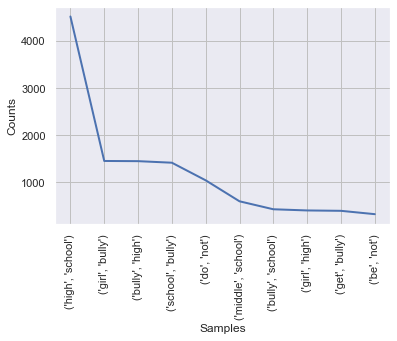

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [36]:
big_freq_age.plot(10)

### Gender

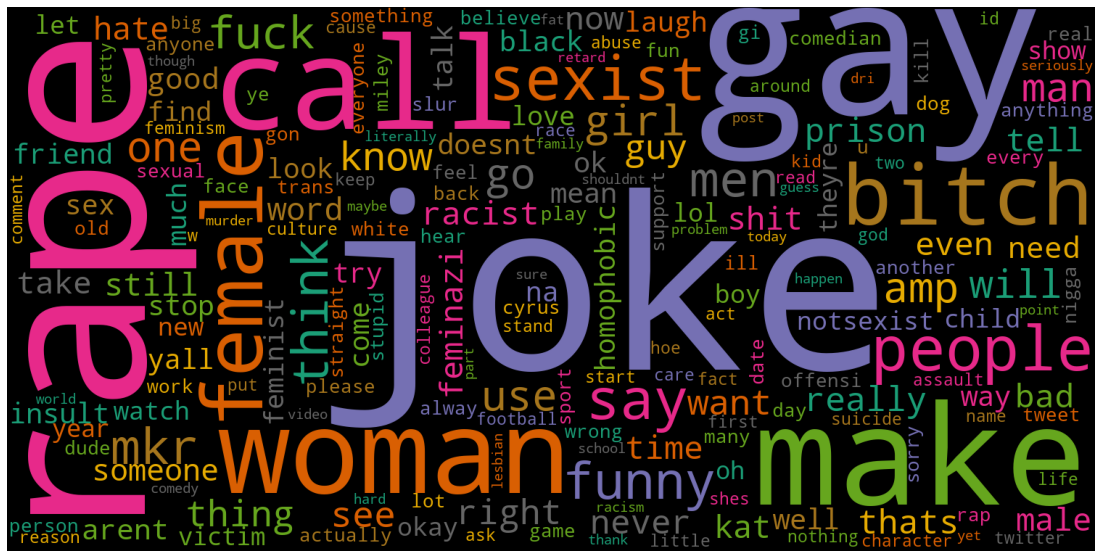

In [37]:
plt.figure(figsize=(20,10))
subset_gen = df[df['Type']==3]

text_gender = list()
for el in subset_gen.Tweet_tokenized.values:
    for i in el:
        text_gender.append(i)
        
cloud1 = WordCloud(background_color='black',colormap="Dark2", 
                   collocations=False,width=1500,height=750).generate(" ".join(text_gender))

plt.axis('off')
plt.imshow(cloud1)

In [38]:
freq_gen = nltk.FreqDist(text_gender)
freq_gen.most_common(10)

[('joke', 5174),
 ('rape', 4067),
 ('gay', 3929),
 ('not', 1829),
 ('make', 1636),
 ('call', 1401),
 ('woman', 1161),
 ('bitch', 1146),
 ('do', 1087),
 ('female', 1084)]

In [39]:
#WORDS FREQUENCY _ 1Gram e 2Gram

bigram_gen = list()
for tweet in subset_gen['Tweet_tokenized']:
    for i in range (0, len(tweet)-1):
        bigram_gen.append((tweet[i], tweet[i+1]))
    
big_freq_gen = nltk.FreqDist(bigram_gen)

big_freq_gen.most_common(20)

[(('rape', 'joke'), 2066),
 (('do', 'not'), 1028),
 (('gay', 'joke'), 786),
 (('joke', 'rape'), 444),
 (('joke', 'gay'), 443),
 (('gay', 'rape'), 437),
 (('make', 'rape'), 399),
 (('can', 'not'), 364),
 (('be', 'not'), 353),
 (('you', 'be'), 286),
 (('call', 'female'), 247),
 (('make', 'joke'), 237),
 (('rape', 'gay'), 234),
 (('gay', 'people'), 221),
 (('make', 'gay'), 193),
 (('prison', 'rape'), 185),
 (('call', 'bitch'), 172),
 (('call', 'sexist'), 145),
 (('fuck', 'bitch'), 137),
 (('gay', 'men'), 129)]

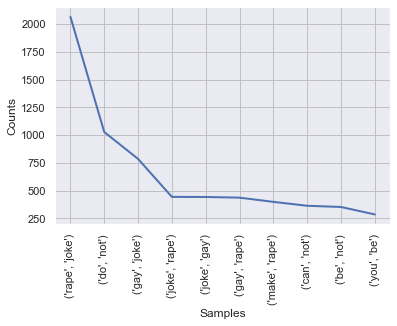

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [40]:
big_freq_gen.plot(10)

### Ethnicity

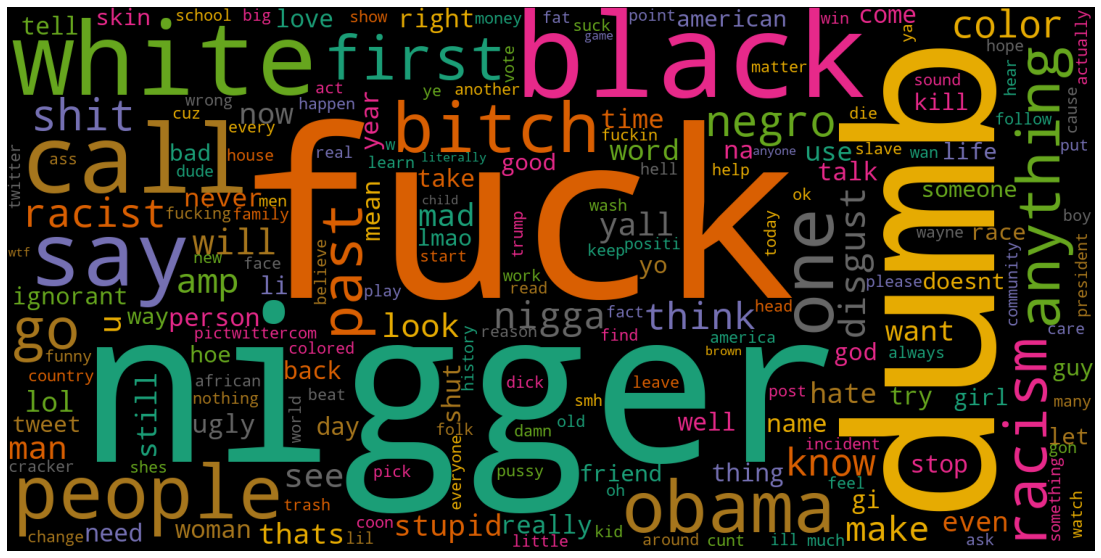

In [41]:
plt.figure(figsize=(20,10))
subset_eth = df[df['Type']==4]

text_eth = list()
for el in subset_eth.Tweet_tokenized.values:
    for i in el:
        text_eth.append(i)
        
cloud1 = WordCloud(background_color='black',colormap="Dark2", 
                   collocations=False,width=1500,height=750).generate(" ".join(text_eth))

plt.axis('off')
#plt.title("Ethnicity",fontsize=40)
plt.imshow(cloud1)

In [42]:
freq_eth = nltk.FreqDist(text_eth)
freq_eth.most_common(10)

[('fuck', 5724),
 ('nigger', 5428),
 ('dumb', 4963),
 ('black', 2142),
 ('as', 2122),
 ('not', 1740),
 ('white', 1557),
 ('call', 1380),
 ('say', 1191),
 ('people', 1180)]

In [43]:
#WORDS FREQUENCY _ 1Gram e 2Gram

bigram_eth = list()
for tweet in subset_eth['Tweet_tokenized']:
    for i in range (0, len(tweet)-1):
        bigram_eth.append((tweet[i], tweet[i+1]))
    
big_freq_eth = nltk.FreqDist(bigram_eth)

big_freq_eth.most_common(20)

[(('dumb', 'as'), 1460),
 (('as', 'nigger'), 1191),
 (('dumb', 'nigger'), 1088),
 (('dumb', 'fuck'), 1058),
 (('do', 'not'), 1009),
 (('fuck', 'obama'), 941),
 (('obama', 'dumb'), 922),
 (('fuck', 'dumb'), 653),
 (('fuck', 'nigger'), 374),
 (('black', 'people'), 347),
 (('be', 'not'), 309),
 (('you', 'be'), 303),
 (('can', 'not'), 303),
 (('nigger', 'fuck'), 289),
 (('white', 'people'), 239),
 (('nigger', 'dumb'), 225),
 (('li', 'have'), 187),
 (('shut', 'fuck'), 180),
 (('gi', 'have'), 178),
 (('call', 'nigger'), 169)]

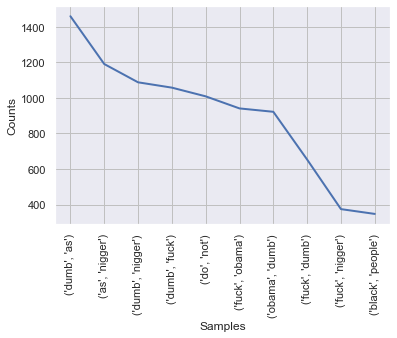

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [44]:
big_freq_eth.plot(10)

In [45]:
#df_clean = df.copy()

In [46]:
#cleaden_tweet is with stop_words

#df_clean.to_csv("Data/cleaned_tweet.csv") 